<a href="https://colab.research.google.com/github/vantainguyen/MagField_DataGen_Deep-learning/blob/main/Codes_utilized_in_the_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Plain-DNN for magnetic field 

## Navigating to the working directory containing the datasets and model

In [ ]:
#Download data to google drive
#!pip install google.colab
from google.colab import drive
import os

useGoogleDrive=True

if useGoogleDrive:
  drive.mount('/content/gdrive', force_remount=True)
  os.chdir("/content/gdrive/My Drive")
  if os.path.isdir("Data_and_model"):
    os.chdir("/content/gdrive/My Drive/Data_and_model")
  else:
    !mkdir -p /content/gdrive/My\ Drive/Data_and_model
    os.chdir("/content/gdrive/My Drive/Data_and_model")

Mounted at /content/gdrive


In [ ]:
import os

if os.path.isdir('EC_data_4m') and os.path.isdir('Cone_data_4m'):
  print ("exists already - skipping")
else:
  !wget https://osf.io/gt8h9/download
  !unzip 'download'
  !rm 'download'




--2022-05-04 00:31:59--  https://osf.io/gt8h9/download
Resolving osf.io (osf.io)... 35.190.84.173
Connecting to osf.io (osf.io)|35.190.84.173|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://files.au-1.osf.io/v1/resources/e3g82/providers/osfstorage/624d252db88dd400b61cbde5?action=download&direct&version=1 [following]
--2022-05-04 00:31:59--  https://files.au-1.osf.io/v1/resources/e3g82/providers/osfstorage/624d252db88dd400b61cbde5?action=download&direct&version=1
Resolving files.au-1.osf.io (files.au-1.osf.io)... 35.241.28.215
Connecting to files.au-1.osf.io (files.au-1.osf.io)|35.241.28.215|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1973290236 (1.8G) [application/octet-stream]
Saving to: ‘download’

download            100%[===================>]   1.84G  13.6MB/s    in 2m 26s  

2022-05-04 00:34:29 (12.9 MB/s) - ‘download’ saved [1973290236/1973290236]

Archive:  download
replace Data_and_model/Cone_data_4m/Data_cone

In [ ]:
import os
os.getcwd()
# os.chdir('/content/Data_and_model/')



'/content/gdrive/MyDrive/Data_and_model'

## Choosing geometries of permanent magnets

In [ ]:
# Which geometry you want to work on 1: Elliptical cylinder; 2: Cone; 3: Paraboloid

geo = ['Elliptical cylinder', 'Cone']
k = 2
bol = True

while bol:
  geometry = int(input("Please insert number 1, 2for Elliptical cylinder, Cone: "))
  if geometry == 1 or geometry == 2:
    print("You have choose to work on "+ geo[geometry - 1])
    bol = False
  else:
    k -= 1
    print(f"Input is not 1 or 2; you have {k} atempts last")
    if k == 0:
      print('You have failed to choose a geometry: Please execute the cell again')
      break


Please insert number 1, 2for Elliptical cylinder, Cone: 2
You have choose to work on Cone


In [ ]:
os.chdir('Data_and_model')

In [ ]:
!ls

Cone_data_4m  EC_data_4m


In [ ]:
source_file = True
folder = ['EC_data_4m', 'Cone_data_4m']

if source_file:
  #os.chdir('Data_and_model') # Change directory to Data_and_model (dowloaded from the OSF) folder if needed
  source_file = os.getcwd()
  source_file = os.path.join(source_file, folder[geometry - 1])
else:
  source_file = '/home/opc/vantai/EC_data_4m'



## Checking the current working GPU

In [ ]:
!nvidia-smi

Wed Apr  6 05:38:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Loading ready processed datasets

In [ ]:
import pickle
import os

os.chdir(source_file)

# Replace _ax with _az or _ra for the azimuthal or radial component

with open('re_s_x_train_scaled_az', 'rb') as filename:
  s_x_train_scaled = pickle.load(filename)

with open('re_s_y_train_scaled_az', 'rb') as filename:
  s_y_train_scaled = pickle.load(filename)

with open('re_s_x_test_scaled_az', 'rb') as filename:
  s_x_test_scaled = pickle.load(filename)

with open('re_s_y_test_scaled_az', 'rb') as filename:
  s_y_test_scaled = pickle.load(filename)

with open('re_x_sScaler_az', 'rb') as filename:
  x_sScaler = pickle.load(filename)

with open('re_y_sScaler_az', 'rb') as filename:
  y_sScaler = pickle.load(filename)



## PlainDNN model development

In [ ]:
# Plain DNN model


import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Add, Concatenate, Activation


# Define a customised loss function

rmse = False # Define a root mean square loss
if rmse:
  def loss_func(y_true, y_pred): 
      
      # Root mean square loss
      squared_difference = tf.square(y_true - y_pred)
      mean_square_loss = tf.reduce_mean(squared_difference, axis=-1)
      root_mean_square_loss = tf.sqrt(mean_square_loss)
      
      return root_mean_square_loss 
else:
  loss_func = 'mse'


class PlainDNNModel(tf.keras.Model):
    def __init__(self):
        
        super(PlainDNNModel, self).__init__()
        
        self.dense1_1 = tf.keras.layers.Dense(796, activation=tf.nn.relu)
        self.dense1_2 = tf.keras.layers.Dense(796, activation=tf.nn.relu)
        self.dense1_3 = tf.keras.layers.Dense(796, activation=tf.nn.relu)


        self.dense2_1 = tf.keras.layers.Dense(796, activation=tf.nn.relu)
        self.dense2_2 = tf.keras.layers.Dense(796, activation=tf.nn.relu)
        self.dense2_3 = tf.keras.layers.Dense(796, activation=tf.nn.relu)


        self.dense3_1 = tf.keras.layers.Dense(796, activation=tf.nn.relu)
        self.dense3_2 = tf.keras.layers.Dense(796, activation=tf.nn.relu)
        self.dense3_3 = tf.keras.layers.Dense(796, activation=tf.nn.relu)
        self.dense3_4 = tf.keras.layers.Dense(796, activation=tf.nn.relu)
        self.dense3_o = tf.keras.layers.Dense(1)

        
    def call(self, inputs):
        
        x_1 = self.dense1_1(inputs)
        x_1 = self.dense1_2(x_1)
        x_1 = self.dense1_3(x_1)

        x_2 = self.dense2_1(x_1)
        x_2 = self.dense2_2(x_2)
        x_2 = self.dense2_3(x_2)

        x_3 = self.dense3_1(x_2)
        x_3 = self.dense3_2(x_3)
        x_3 = self.dense3_3(x_3)
        x_3 = self.dense3_4(x_3)
        x_3 = self.dense3_o(x_3)
           
        return x_3
    

PlainModel = PlainDNNModel()  


opt = tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=True, beta_1=.9, beta_2=.9999)

PlainModel.compile(optimizer=opt, loss=loss_func)

## Loading pre-trained model

In [ ]:
import tensorflow as tf
import os
import numpy as np
from tensorflow.keras.layers import Add, Concatenate, Activation


# Define a customised loss function
rmse = False
if rmse:
  def loss_func(y_true, y_pred): 
      
      # Root mean square loss
      squared_difference = tf.square(y_true - y_pred)
      mean_square_loss = tf.reduce_mean(squared_difference, axis=-1)
      root_mean_square_loss = tf.sqrt(mean_square_loss + 1e-20)
      
      return root_mean_square_loss 
else:
  loss_func = 'mse'

source_file_model = os.path.join(source_file, 're_HDNNmodel_IQR_az') # Replace _ax with _az or _ra for the azimuthal or radial component
if os.getcwd != source_file_model:
  os.chdir(source_file_model)

PlainModel = PlainDNNModel()  

if geometry == 1:
  PlainModel.load_weights('PlainDNN_400_796_clean') 
elif geometry == 2:
  PlainModel.load_weights('PlainDNN_400_796_clean')



opt = tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=True, beta_1=.9, beta_2=.9999 )

PlainModel.compile(optimizer=opt, loss=loss_func) 



## Training new model

In [ ]:
import pickle
import time
import os
from datetime import datetime
%load_ext tensorboard

now = datetime.now()

source_file_model = os.path.join(source_file, 're_HDNNmodel_IQR_ax') # Replace _ax with _az or _ra for the azimuthal or radial component
if os.getcwd != source_file_model:
  os.chdir(source_file_model)



filepath = os.path.join(os.getcwd(), 'PlainDNN_400_796_clean') # Save as your desire

modelcheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath, monitor='val_loss', 
                                                     mode='min', verbose=1, save_best_only=True, save_weights_only=True)

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, mode='min', patience=20, min_delta=0.00005)

new_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', verbose=1, patience=10, 
                                              factor=1/10, min_lr=1e-5)

path = "logs/fit/" + now.strftime("%Y/%m/%/d, %H/%M")

#tensorboard = tf.keras.callbacks.TensorBoard(log_dir=path, histogram_freq=1)

st = time.time()

history = PlainModel.fit(s_x_train_scaled, s_y_train_scaled, validation_split=.20, 
                     batch_size=512, epochs=400, callbacks=[earlystopping, modelcheckpoint, new_lr])

used_time = time.time() - st

with open('p796_history_400_clean', 'wb') as filename:
  pickle.dump(history.history, filename)

with open('p796_used_time_400_clean', 'wb') as filename:
  pickle.dump(used_time, filename)



In [ ]:
PlainModel.summary()

Model: "plain_dnn_model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_88 (Dense)            multiple                  6368      
                                                                 
 dense_89 (Dense)            multiple                  634412    
                                                                 
 dense_90 (Dense)            multiple                  634412    
                                                                 
 dense_91 (Dense)            multiple                  634412    
                                                                 
 dense_92 (Dense)            multiple                  634412    
                                                                 
 dense_93 (Dense)            multiple                  634412    
                                                                 
 dense_94 (Dense)            multiple            

##Training history

Text(0, 0.5, 'Errors')

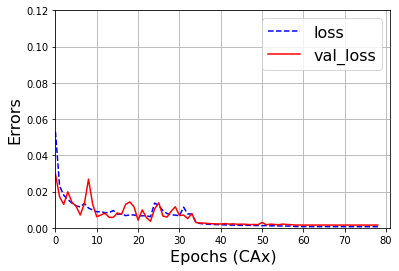

In [ ]:
import pickle
import os
import pandas as pd
import matplotlib.pyplot as plt

source_file = '/content/Data_and_model/Cone_data_4m'
source_file_model = os.path.join(source_file, 're_HDNNmodel_IQR_ax')

if os.getcwd() != source_file_model:
  os.chdir(source_file_model)

with open('p796_history_400_clean', 'rb') as filename:
  hist1 = pickle.load(filename)

pdhist1 = pd.DataFrame(hist1)

pdhist1['loss'].plot(linestyle='--', c='b')
pdhist1['val_loss'].plot(c='r')

plt.legend(loc='upper right', fontsize=16)
plt.grid()
plt.xlim(0, 81)
plt.ylim(0, 0.12)

plt.xlabel('Epochs (CAx)', fontsize=16)
plt.ylabel('Errors', fontsize=16)


## Model testing

In [ ]:
# Predicting the results
s_y_predicted_scaled = PlainModel.predict(s_x_test_scaled)

### R-squared test

In [ ]:
# Testing the model
from sklearn.metrics import r2_score

r2_score(s_y_test_scaled, s_y_predicted_scaled)

0.9987114009746431

### Pearson correlation test

In [ ]:
import scipy.stats as ss

ss.pearsonr(np.squeeze(s_y_test_scaled), np.squeeze(s_y_predicted_scaled))

(0.9993555270829454, 0.0)

###Scatter plot

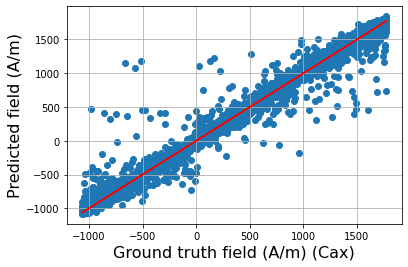

In [ ]:
import matplotlib.pyplot as plt
y_pred = y_sScaler.inverse_transform(s_y_predicted_scaled)
y_test = y_sScaler.inverse_transform(s_y_test_scaled)
a, b = np.polyfit(np.squeeze(y_test), np.squeeze(y_pred), 1)
plt.scatter(y_test, y_pred)
plt.plot(y_test, a*y_test+b, color='r')

plt.xlabel('Ground truth field (A/m) (Cax)', fontsize=16)
plt.ylabel('Predicted field (A/m)', fontsize=16)
plt.grid('on')

### Kernel density estimation

mean: 0.2704050943233411, std: 1.0516878016436386


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


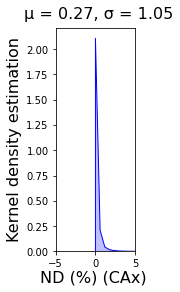

In [ ]:
# Plotting pairs
# Not normalized
import seaborn as sns

height = [0.00148, 0.788, 0.00395]
low = [-0.000227, -0.12, -0.000588]
plt.figure(figsize=(10, 14))

interq_955 = np.subtract(*np.percentile(y_test, [95, 5]))
errors = abs(y_pred - y_test)*100/interq_955


plt.subplot(342)
mean = np.mean(errors)
std = np.std(errors)

print('mean: {}, std: {}'.format(mean, std))

sns.distplot(errors, kde=True, hist=False, rug=False, kde_kws={"shade": True, "bw_adjust": 1, "cut":0, "bw_method": 'silverman'}, color='b')
#sns.kdeplot(data=errors, fill=True)
plt.xlim(-5, 5)
plt.text(-7, -0.3, 'ND (%) (CAx)', fontsize=16)
#plt.text(-20, 1.6*low[index_+1], 'j) Azimuthal component', fontsize=12)
# #plt.xlabel('b) Azimuthal component', fontsize=12)
plt.ylabel('Kernel density estimation', fontsize=16)
plt.text(-9, 2.3, '\u03BC = {:2.2}, \u03C3 = {:0.3}'.format(mean, std), fontsize=16) # height index_ .2 for axial; = 6.5 for azimuthal and .42 for radial
# #plt.tight_layout(rect=(0., 0., 1, 1))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1., hspace=None)










## Codes for generating new training/validation/testing datasets

In [ ]:
if os.path.isdir('Magnetised_Cone') and os.path.isdir('Magnetised_Elliptical_Cylinder'):
  print ("exists already - skipping")
else:
  !wget https://osf.io/48nbk/download
  !unzip 'download'
  !rm 'download'

print('The Python codes to generate new training/validation/testing datasets are now located in these subfolders')

--2022-04-06 05:42:57--  https://osf.io/48nbk/download
Resolving osf.io (osf.io)... 35.190.84.173
Connecting to osf.io (osf.io)|35.190.84.173|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://files.au-1.osf.io/v1/resources/e3g82/providers/osfstorage/619d93710528780096ab239c?action=download&direct&version=1 [following]
--2022-04-06 05:42:58--  https://files.au-1.osf.io/v1/resources/e3g82/providers/osfstorage/619d93710528780096ab239c?action=download&direct&version=1
Resolving files.au-1.osf.io (files.au-1.osf.io)... 35.241.28.215
Connecting to files.au-1.osf.io (files.au-1.osf.io)|35.241.28.215|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 127889990 (122M) [application/octet-stream]
Saving to: ‘download’

download            100%[===================>] 121.96M  20.9MB/s    in 7.1s    

2022-04-06 05:43:06 (17.3 MB/s) - ‘download’ saved [127889990/127889990]

Archive:  download
   creating: Magnetised_Cone/
  inflating: Magne